# Bike Sharing Assignment


Business objective :

  'BoomBikes' provides bike-sharing service in which bikes are made available for shared use to individuals on a short term basis for a price or free.The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

Goal:

    Build a multiple linear regression model for the prediction of demand for shared bikes. 


# Step 1: Reading and Understanding the Data

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import calendar 

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# Read csv file
day = pd.read_csv('day.csv')
day.head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510
7,8,08-01-2018,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,68,891,959
8,9,09-01-2018,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,54,768,822
9,10,10-01-2018,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,41,1280,1321


In [3]:
day.shape

(730, 16)

In [4]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### Drop variables:

1. instant - contains record index
2. dteday - date/month/year . but dataframe has seperate columns for month , year and day
3. casual- count of casual users 
4. registered - count of registered users

cnt = casual + registered 

In [5]:
# Drop instant ,dteday,casual,registered

day = day.drop(['instant','dteday','casual','registered'],axis=1)
day.shape

(730, 12)

Target variable :  cnt = casual + registered 

### Lable categories :

Some variables in the dataframe have values such as 0,1,2 etc with lables asssociated with them . So convert
those variables into categorical string values before dummy encoding .
- The variables are : mnth , season, weathersit and weekday

Convert numeric values in 'mnth' into categorical strings .
- 0- January
- 1- Feb  etc.


In [6]:
# mnth
# calendar library is used to name months depending of numbers . 0- january etc
day['mnth'] = day['mnth'].apply(lambda x:calendar.month_name[x])
day.mnth

0       January
1       January
2       January
3       January
4       January
         ...   
725    December
726    December
727    December
728    December
729    December
Name: mnth, Length: 730, dtype: object

In [7]:
# season lables are given in the dataset characteristics

day['season'] = day['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

#### Lable 'weekday' :
- with reference to the given 'workingday' , 'weekdays' are labeled as given below :
- In 'workingday' - > 0 - saturday,sunday and 1 - monday to friday
- 'weekdays' are represented by : 0-'sunday',1-'monday',2-'tuesday',3-'wednesday',4-'thursday',5-'friday',6-'saturday'

In [8]:
# weekdays numbers to days

day['weekday'] = day['weekday'].map({0:'sunday',1:'monday',2:'tuesday',3:'wednesday',4:'thursday',5:'friday',6:'saturday'})
day.weekday

0       saturday
1         sunday
2         monday
3        tuesday
4      wednesday
         ...    
725     thursday
726       friday
727     saturday
728       sunday
729       monday
Name: weekday, Length: 730, dtype: object

In [9]:
# chaging weathersit 
# 4 -> Heavy snow is not in data frame
day['weathersit'] = day['weathersit'].map({1:'clear',2:'mist',3:'light snow'})

#### Round decimal points :
- Round upto 2 decimal places for columns temp, atemp , hum , windspeed .

In [10]:
# round upto 2 decimal places 

day['temp'] = day['temp'].apply(lambda x:round(x,2))
day['atemp'] = day['atemp'].apply(lambda x:round(x,2))
day['hum'] = day['hum'].apply(lambda x:round(x,2))
day['windspeed'] = day['windspeed'].apply(lambda x:round(x,2))


In [11]:
# check data types 
day.dtypes

season         object
yr              int64
mnth           object
holiday         int64
weekday        object
workingday      int64
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

All columns have appropriate data type .

In [12]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,January,0,saturday,0,mist,14.11,18.18,80.58,10.75,985
1,spring,0,January,0,sunday,0,mist,14.90,17.69,69.61,16.65,801
2,spring,0,January,0,monday,1,clear,8.05,9.47,43.73,16.64,1349
3,spring,0,January,0,tuesday,1,clear,8.20,10.61,59.04,10.74,1562
4,spring,0,January,0,wednesday,1,clear,9.31,11.46,43.70,12.52,1600


# Step 2: Visualising the Data

#### Visualise numeric variables :

Here heatmap is used to compare correlation between numeric variables.

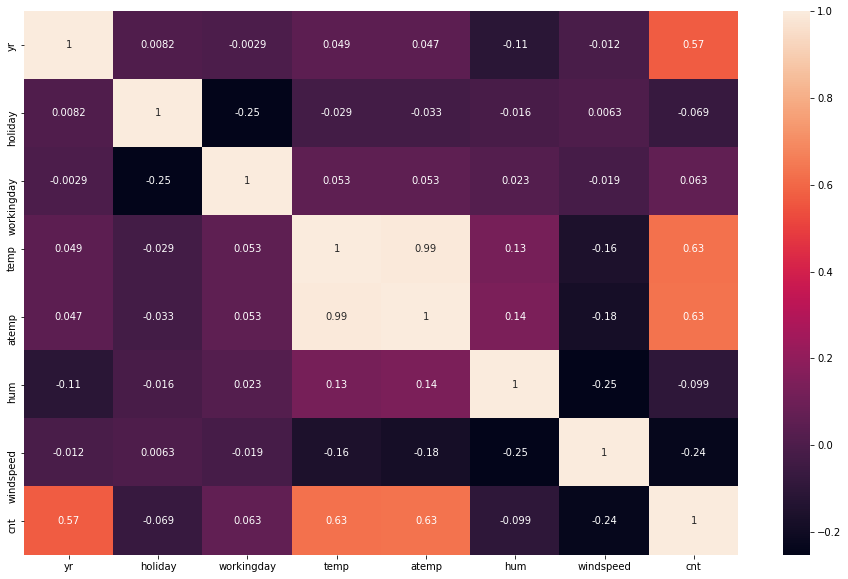

In [13]:
# heatmp
plt.figure(figsize = (16, 10))
sns.heatmap(day.corr(),annot=True)
plt.show()

From above : 

- 'yr' and 'cnt' are correlated.
- temp and atemp have high correlation = 0.99 . Drop any one variable.
    - temp : temperature in Celsius 
    - atemp: feeling temperature in Celsius

In [14]:
# drop temp

day = day.drop('temp',axis=1)
day.shape

(730, 11)

#### Visualising Categorical Variables:
Here subplot is used to plot categorical variables .


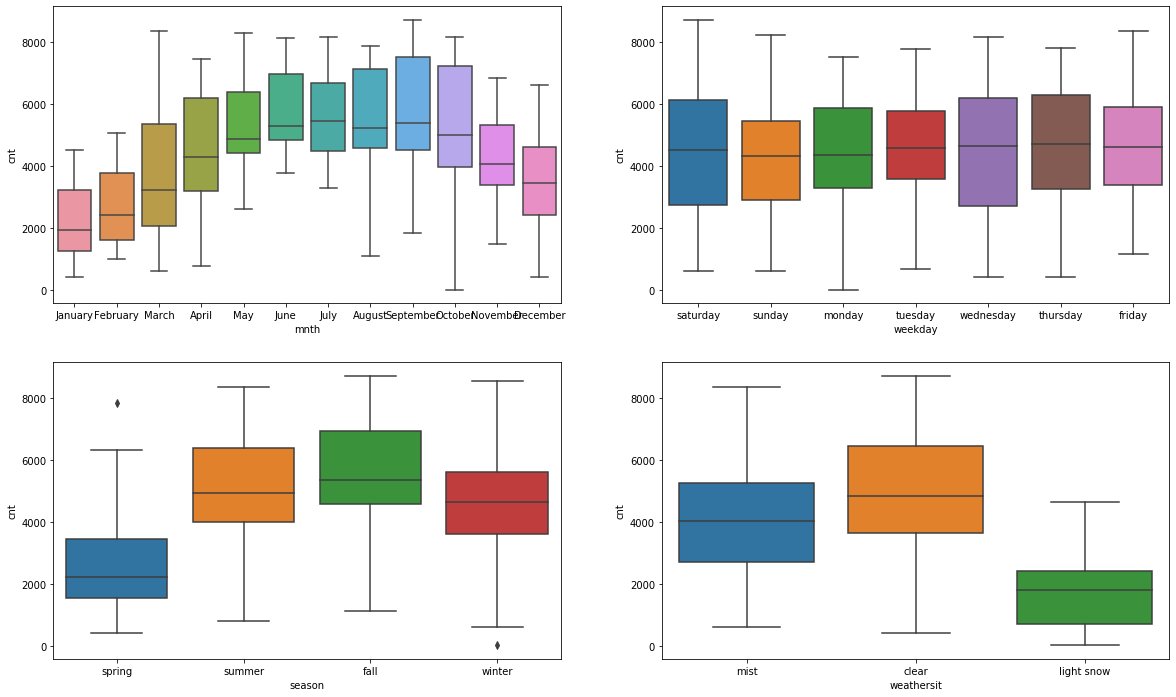

In [15]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'mnth', y = 'cnt', data = day)

plt.subplot(2,2,2)
sns.boxplot(x = 'weekday', y = 'cnt', data = day)

plt.subplot(2,2,3)
sns.boxplot(x = 'season', y = 'cnt', data = day)

plt.subplot(2,2,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = day)
plt.show()

From above plots:
- 'weekdays' - > mean value appoximately equal throught the week


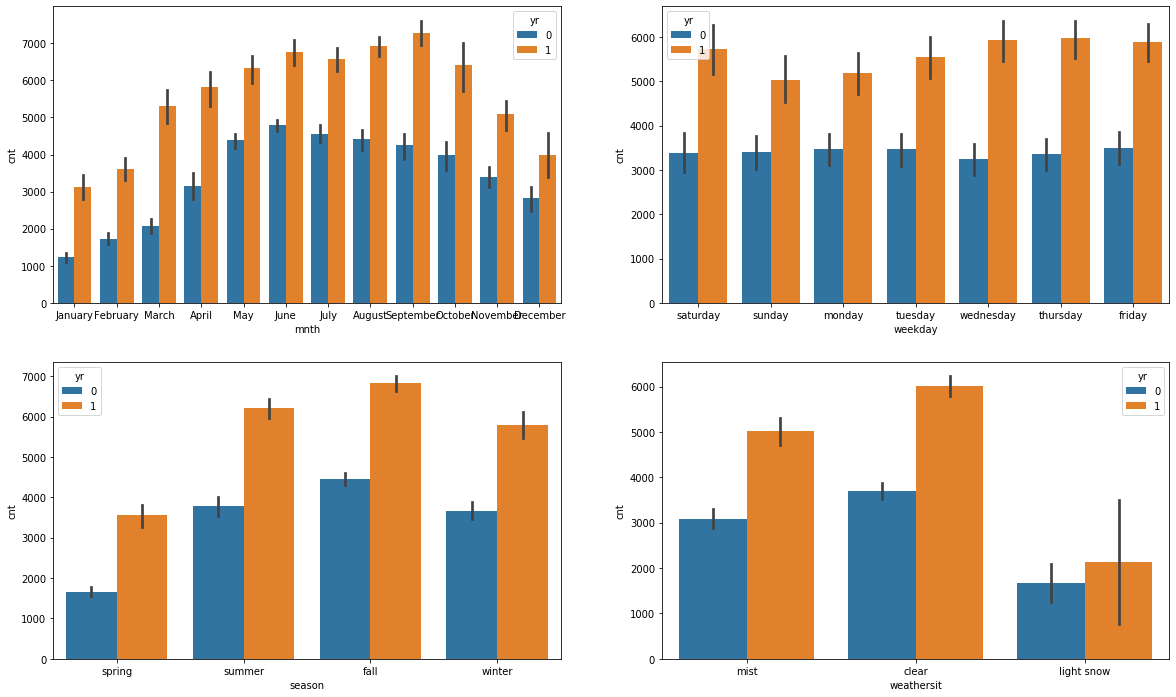

In [16]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.barplot(x = 'mnth', y = 'cnt',hue = 'yr', data = day)

plt.subplot(2,2,2)
sns.barplot(x = 'weekday',y = 'cnt',hue = 'yr', data = day)

plt.subplot(2,2,3)
sns.barplot(x = 'season',y = 'cnt',hue = 'yr', data = day)

plt.subplot(2,2,4)
sns.barplot(x = 'weathersit', y = 'cnt',hue = 'yr', data = day)
plt.show()

From above plot :
    - Bike renting requirement has increased from 2018 to 2019 .
    - so 'yr' is one of the key predictor variable which is also explaind by the heat map

#### visualise month based on season, holiday and weather situation

<function matplotlib.pyplot.show(*args, **kw)>

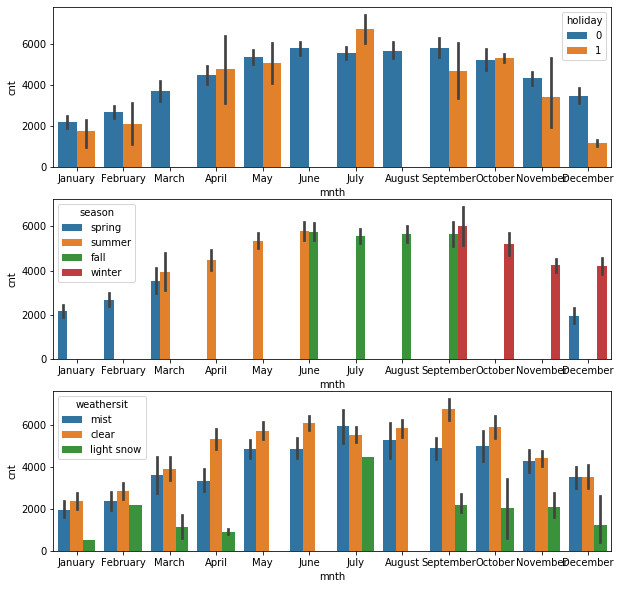

In [17]:
# monthwise analysis on season, holiday and weather situation
plt.figure(figsize = (10,10))

plt.subplot(3,1,1)
sns.barplot(x = 'mnth', y = 'cnt',hue = 'holiday', data = day)

plt.subplot(3,1,2)
sns.barplot(x = 'mnth', y = 'cnt',hue = 'season', data = day)

plt.subplot(3,1,3)
sns.barplot(x = 'mnth', y = 'cnt',hue = 'weathersit', data = day)
plt.show

From above plot it is observed that :
- number of holidays is highest in July, so the demand is highest .
- the weather situation is best(clear sky) in September, so the demand is highest

<function matplotlib.pyplot.show(*args, **kw)>

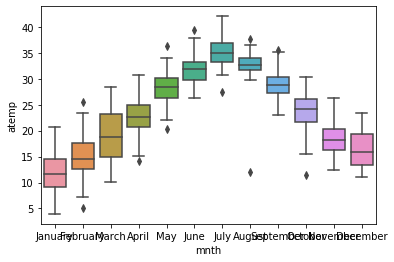

In [18]:

sns.boxplot(x = 'mnth', y = 'atemp', data = day)
plt.show


- Feeling tempeture lowest in January and it affects bike renting .

# Step 3: Data Preparation

### Dummy Variables:

Few categorical columns in the dataframe has category levels , convert those levels into binary form.

In [19]:
# Create dummy variables
# drop_first=True -> drops the first column in ascending order

mnth_dummy = pd.get_dummies(day['mnth'],drop_first=True)
weathersit_dummy = pd.get_dummies(day['weathersit'],drop_first=True)
weekday_dummy = pd.get_dummies(day['weekday'],drop_first=True)
season_dummy = pd.get_dummies(day['season'],drop_first=True)

Following categorical labels are dropped after performing dummy encoding (drop_first=True) .
    These are reduntant,
    - 1. April in months
    - 2. Clear in weather situation
    - 3. Friday in weekdays
    - 4. fall in season
    

Join all the dummy encoded column with the main dataframe . And drop the columns on which we performed dummy encoding.

In [20]:
# Join all the dfs 
day = pd.concat ([day ,mnth_dummy,weathersit_dummy,weekday_dummy,season_dummy],axis=1)

# drop the categorical variables on which dummy encoding is performed
day = day.drop(['mnth','season','weekday','weathersit'],axis=1)

In [21]:
day.shape

(730, 29)

In [22]:
# A check on column names
day.columns

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'cnt',
       'August', 'December', 'February', 'January', 'July', 'June', 'March',
       'May', 'November', 'October', 'September', 'light snow', 'mist',
       'monday', 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday',
       'spring', 'summer', 'winter'],
      dtype='object')

# Step 4: Splitting the Data into Training and Testing Sets

Split the main dataframe into randomly sampled train and test set . split ratio is train:test = 70% : 30% 

In [23]:
# Train test split
df_train, df_test = train_test_split(day, train_size = 0.7, test_size = 0.3, random_state = 100)


### Rescaling the Features :

Variables have different scales , it affects their interpretation . To avoid this problem scaling has to be done .

Minmax scaling is used here.

In [24]:
#create an object

scaler = MinMaxScaler()

In [25]:
# minmax scaling has to be performed on numeric variables except dummy variables and variables which have only 0 ,1 .

num_vars = ['atemp', 'hum', 'windspeed', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [26]:
# check min and max values = 0 and 1

df_train.describe()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,August,December,February,...,mist,monday,saturday,sunday,thursday,tuesday,wednesday,spring,summer,winter
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000
mean,0.507843,0.025490,0.676471,0.513097,0.650378,0.320866,0.513620,0.096078,0.084314,0.066667,...,0.343137,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.243137,0.245098,0.24902
std,0.500429,0.157763,0.468282,0.212394,0.145885,0.169770,0.224593,0.294988,0.278131,0.249689,...,0.475223,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.429398,0.430568,0.43287
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.332174,0.538644,0.199230,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,0.000000,1.000000,0.527041,0.653751,0.296760,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,0.000000,1.000000,0.688632,0.754818,0.414501,0.684710,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### Dividing into X and Y sets for the model building

- 'cnt'=y_train  -> target variable .
- X_train -> whole train dataframe except target variable


In [27]:
# create X_train , y_train
y_train = df_train.pop('cnt')
X_train = df_train

# Step 5: Building a multiple linear regression model

In this assignment automated feature selection method 'RFE 'is used along with manual fine tuning . 

- RFE - to select top 13 predictors
- manual analysis - to get top predictors

### RFE
Recursive feature elimination

In [28]:
# create LinearRegression object
lm = LinearRegression()

# Fit the train model
lm.fit(X_train, y_train)

# perform RFE on top 13 features 
rfe = RFE(lm, 13)             
rfe = rfe.fit(X_train, y_train)

In [29]:
# Display predictor variables based on the rank and 

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 4),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('August', False, 8),
 ('December', False, 2),
 ('February', False, 5),
 ('January', True, 1),
 ('July', True, 1),
 ('June', False, 9),
 ('March', False, 16),
 ('May', False, 6),
 ('November', True, 1),
 ('October', False, 14),
 ('September', True, 1),
 ('light snow', True, 1),
 ('mist', True, 1),
 ('monday', False, 11),
 ('saturday', False, 3),
 ('sunday', False, 10),
 ('thursday', False, 13),
 ('tuesday', False, 12),
 ('wednesday', False, 15),
 ('spring', True, 1),
 ('summer', False, 7),
 ('winter', True, 1)]

In [30]:
# Collect predictor variables which are selected by RFE 
col = X_train.columns[rfe.support_]

### Analysis 1 :  top 13 predictors

- Create 'X_train_13' dataframe to store top 13 predictor variables which are found by RFE . 
- Build the model and perform manual analysis by comparing R2 , p-value and adjusted r2 to get Top predictor variables .

In [31]:
# Creating X_train_13 dataframe with RFE selected predictor variables
X_train_13 = X_train[col]
X_train_13.shape

(510, 13)

- add constant to the dataframe 'X_train_13' to get an interceptor and create 'X_train_rfe'dataframe and build the model
- use data frame 'X_train_rfe' to perform manual analysis .

In [32]:
# add a constant to get an interceptor
X_train_rfe = sm.add_constant(X_train_13)

# Fit the resgression line using 'OLS'
lm = sm.OLS(y_train,X_train_rfe).fit() 

In [33]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     198.3
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          7.19e-187
Time:                        12:09:00   Log-Likelihood:                 503.66
No. Observations:                 510   AIC:                            -979.3
Df Residuals:                     496   BIC:                            -920.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3567      0.032     11.215      0.000       0.294       0.419
yr             0.2321      0.008     28.212      0.000       0.216       0.248
holiday       -0.0880      0.026     -3.374      0.001      -0.139      -0.037
atemp          0.4727      0.034     13.970      0.000       0.406       0.539
hum           -0.1596      0.038     -4.173      0.000      -0.235      -0.084
windspeed     -0.1615      0.026     -6.179      0.000      -0.213      -0.110
January       -0.0393      0.018     -2.205      0.028      -0.074      -0.004
July          -0.0714      0.017     -4.124      0.000      -0.105      -0.037
November      -0.0315      0.017     -1.805      0.072      -0.066       0.003
September      0.0621      0.016      3.955      0.000       0.031       0.093
light snow    -0.2414      0.027     -9.023      0.000      -0.294      -0.189
mist          -0.0558      0.011     -5.242      0.000      -0.077      -0.035
spring        -0.1076      0.015     -6.958      0.000      -0.138      -0.077
winter         0.0543      0.013      4.043      0.000       0.028       0.081
==============================================================================
Omnibus:                       59.911   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.221
Skew:                          -0.592   Prob(JB):                     1.97e-34
Kurtosis:                       5.429   Cond. No.                         18.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Check VIF:

- Drop 'const' before finding VIF .

In [34]:
# Drop 'const'
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find VIF
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,23.77
2,atemp,16.01
4,windspeed,4.00
11,spring,2.86
12,winter,2.53
10,mist,2.24
0,yr,2.06
5,January,1.67
7,November,1.59
6,July,1.40


From above model :
- 'November' has p-value > 0.05
- 'hum'and 'atemp' have VIF > 5
- Drop variable which has p-value > 0.05 first . This will change vif .

# Analysis 2 :

- Drop 'November' and build the model


In [35]:
# drop 'saturday'
X_train_rfe = X_train_rfe.drop(['November'], axis=1)
X_train_rfe.shape

(510, 12)

In [36]:
#Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit()  

In [37]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     213.6
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          2.43e-187
Time:                        12:09:01   Log-Likelihood:                 501.99
No. Observations:                 510   AIC:                            -978.0
Df Residuals:                     497   BIC:                            -922.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3507      0.032     11.062      0.000       0.288       0.413
yr             0.2321      0.008     28.151      0.000       0.216       0.248
holiday       -0.0937      0.026     -3.612      0.000      -0.145      -0.043
atemp          0.4793      0.034     14.218      0.000       0.413       0.546
hum           -0.1568      0.038     -4.094      0.000      -0.232      -0.082
windspeed     -0.1628      0.026     -6.216      0.000      -0.214      -0.111
January       -0.0386      0.018     -2.162      0.031      -0.074      -0.004
July          -0.0724      0.017     -4.168      0.000      -0.106      -0.038
September      0.0642      0.016      4.090      0.000       0.033       0.095
light snow    -0.2401      0.027     -8.957      0.000      -0.293      -0.187
mist          -0.0557      0.011     -5.217      0.000      -0.077      -0.035
spring        -0.1048      0.015     -6.797      0.000      -0.135      -0.075
winter         0.0448      0.012      3.618      0.000       0.020       0.069
==============================================================================
Omnibus:                       56.992   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.434
Skew:                          -0.568   Prob(JB):                     2.63e-32
Kurtosis:                       5.356   Cond. No.                         18.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# Remove constant term
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

#to find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,23.75
2,atemp,15.94
4,windspeed,3.96
10,spring,2.85
9,mist,2.24
0,yr,2.06
11,winter,2.05
5,January,1.67
6,July,1.40
8,light snow,1.22


From above model :
- all the predictor variables have p value < 0.05
- but vif of 'hum' >5
- so, drop 'hum' and rebuild the model

# Analysis 3 :

- Drop 'hum' and build MLR model.

In [39]:
# Drop 'hum'
X_train_rfe = X_train_rfe.drop(['hum'], axis=1)
X_train_rfe.shape

(510, 11)

In [40]:
# Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit()  

In [41]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     224.4
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          5.82e-185
Time:                        12:09:02   Log-Likelihood:                 493.53
No. Observations:                 510   AIC:                            -963.1
Df Residuals:                     498   BIC:                            -912.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2686      0.025     10.772      0.000       0.220       0.318
yr             0.2358      0.008     28.342      0.000       0.219       0.252
holiday       -0.0944      0.026     -3.582      0.000      -0.146      -0.043
atemp          0.4449      0.033     13.417      0.000       0.380       0.510
windspeed     -0.1348      0.026     -5.250      0.000      -0.185      -0.084
January       -0.0427      0.018     -2.362      0.019      -0.078      -0.007
July          -0.0646      0.018     -3.685      0.000      -0.099      -0.030
September      0.0610      0.016      3.831      0.000       0.030       0.092
light snow    -0.2834      0.025    -11.332      0.000      -0.333      -0.234
mist          -0.0807      0.009     -9.099      0.000      -0.098      -0.063
spring        -0.1079      0.016     -6.899      0.000      -0.139      -0.077
winter         0.0351      0.012      2.843      0.005       0.011       0.059
==============================================================================
Omnibus:                       59.176   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.775
Skew:                          -0.604   Prob(JB):                     3.65e-32
Kurtosis:                       5.314   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# Drop constant before finding vif
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,4.54
3,windspeed,3.91
9,spring,2.24
0,yr,2.06
4,January,1.60
8,mist,1.53
10,winter,1.40
5,July,1.35
6,September,1.20
7,light snow,1.08


From above analysis of train set:
    - for all predictor variables p <0.05 and vif < 5
 

# Step 6: Residual Analysis of the train data

- check on error terms (residuals)
    - nomally distribution - distplot
    - constant variance - scatter plot

In [43]:
# create new df and add contant term

X_train_lm = sm.add_constant(X_train_rfe)

In [44]:
# predit y_train_cnt
y_train_cnt = lm.predict(X_train_lm)

<function matplotlib.pyplot.show(*args, **kw)>

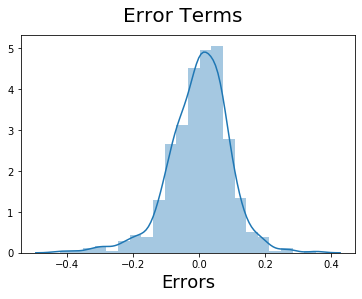

In [45]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 22)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)                         
plt.show

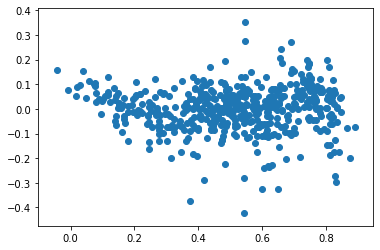

In [46]:
# Scatterplot on error terms
# res = difference between y valus and predicted y value
res = (y_train - y_train_cnt)

plt.scatter(y_train_cnt,res)

- From the plots it is visible that error terms are normally distributed with constant variance .

## Step 7: Making Predictions on Test set

     Now that the model is ready . perform analysis on test set.
         - scale the predictor variables that are scaled in train set
         


In [47]:
# perform scaling - transform()
num_vars = ['atemp', 'hum', 'windspeed', 'cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])

In [48]:
# create X_test,y_test data frames
y_test = df_test.pop('cnt')
X_test = df_test

- select predictor variables on which the model has been built .

In [49]:
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_rfe.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [50]:
# Making predictions
y_pred = lm.predict(X_test_new)

# Step 8: Model Evaluation

- Plot actual y_test vs predicted y.
- Find r2 value of test set

Text(0, 0.5, 'y_pred')

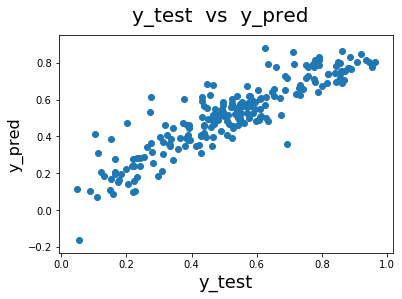

In [51]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test  vs  y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [52]:
# compare r2 score of train and test set

print ( 'r2 score of train set = ', r2_score(y_true = y_train, y_pred=y_train_cnt) )
print ( 'r2 score of test set = ', r2_score(y_true = y_test, y_pred=y_pred) )

r2 score of train set =  0.8321013252958446
r2 score of test set =  0.8051117242411236


### Observations :

The following variables are significant in predicting the demand for shared bikes:

    1. temperature
    2. windspeed
    3. spring and winter season in US
    4. year - the demand increased from 2018 to 2019.
    5. January - feeling temperature is lowest (hence demand is lowest)
    6. July - number of holidays is highest (hence demand is highest)
    7. september - clear sky most prevalent (hence demand is highest)
    8. holiday 
    9. when weather situation is light snow and mist
    
    